# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# importing libraries for VADER  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, root_mean_squared_error
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

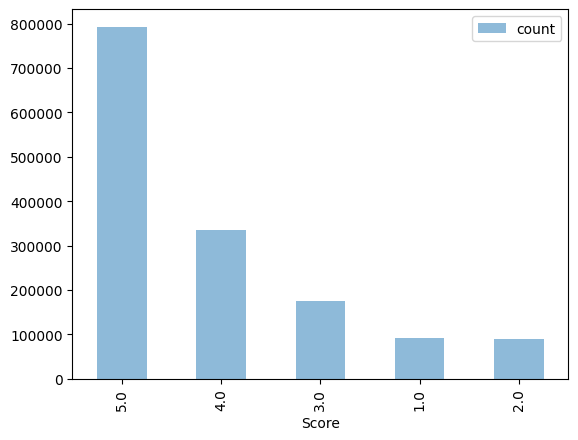


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [6]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER compound score for a given text
def get_vader_sentiment(text, idx):
    if not isinstance(text, str):
        text = ''
    if idx % 100000 == 0:  # Print progress every 100,000 rows
        print(f"Processing row {idx}")
    return analyzer.polarity_scores(text)['compound']

def parallel_vader_sentiment(df, text_column):
    num_cores = multiprocessing.cpu_count()

    sentiment_scores = Parallel(n_jobs=num_cores)(
        delayed(get_vader_sentiment)(text, i) for i, text in enumerate(df[text_column])
    )
    return sentiment_scores

def add_features_to(df):
    # This is where you can do all your feature extraction

    # Calculate 'Helpfulness' feature
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Drop HelpfulnessNumerator and HelpfulnessDenominator
    df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Convert Time to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    # ridge does not work with datetime need to convert to int
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df.drop(columns=['Time'], inplace=True)

    # impute missing values with empty strings
    df['Text'] = df['Text'].fillna('').astype(str)
    df['Summary'] = df['Summary'].fillna('').astype(str)
    # Convert any non-string entries in 'Text' column to strings

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if row['Text'] else 0, axis = 1)

    # Extract the sentiment from the summary and text    
    df['Text_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Text')
    # trainingSet['Summary_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Summary')
    # created a lot of noise

    print(df[['Text_Sentiment']].head())
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame in chunks
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Processing row 0
Processing row 100000
Processing row 200000
Processing row 300000
Processing row 400000
Processing row 500000
Processing row 600000
Processing row 700000
Processing row 800000
Processing row 900000
Processing row 1000000
Processing row 1100000
Processing row 1200000
Processing row 1300000
Processing row 1400000
Processing row 1500000
Processing row 1600000
   Text_Sentiment
0         -0.6205
1          0.4939
2          0.9733
3          0.9750
4          0.9981


# Sample + Split into training and testing set

In [7]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=42
)

In [8]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_submission:", X_submission.columns)

Columns in X_train: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment'],
      dtype='object')
Columns in X_submission: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment', 'Score'],
      dtype='object')


# Feature Selection

In [9]:
features = ['Id', 'Text_Sentiment', 'Helpfulness', 'DayOfWeek', 'ReviewLength']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [10]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='manhattan').fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5228472326949178


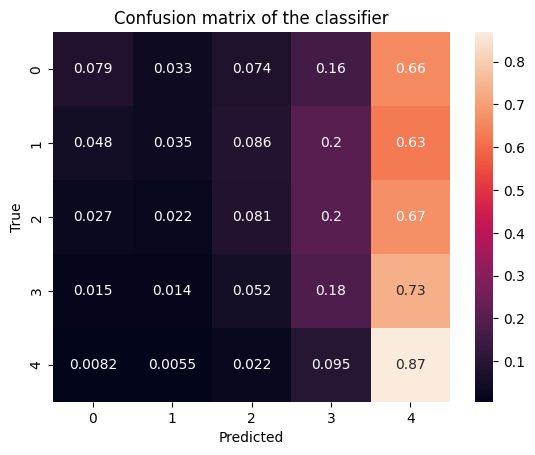

In [11]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [12]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)